extract data => caclulate correlation coefficient and plot it'
1. Once spearman's correlation > 0.9/ 0.95 => entry point;
2. for each element in the pairs, if close > moving average => short
3. if moving average > close => long
4. not sure where's the take profit point/ condition

In [58]:
# However it is important to note that the 1m data is only retrievable for the last 7 days, 
# and anything intraday (interval <1d) only for the last 60 days.
# constrainted to daily
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.stats as ss
# used inside fx_correlation()
def correlation(dataframe, type="spearman"):
    usd = dataframe.iloc[:, 0]
    eur = dataframe.iloc[:, 1]
    if type == "spearman":
        corr = ss.spearmanr(usd, eur)
    elif type == "pearson":
        corr = ss.pearsonr(usd, eur)
    elif type == "kendalltau":
        corr = ss.kendalltau(usd, eur)
    else:
        corr = ss.spearmanr(usd, eur)
    return corr.correlation

def fx_correlation(pairs=["USDCHF", "EURUSD"],type="spearman", data_type="Close", window_size=200, save=True, interval='1d'):
    # data preprocessing
    currency1 = pairs[0]
    currency2 = pairs[1]
    path1 = f"price/" + currency1 + "_" + interval + ".csv"
    path2 = f"price/" + currency2 + "_" + interval + ".csv"
    col_name = "Date" if interval == "1d" else "Datetime" # if interval == "1d", yfinance will return date column, else datetime column name
    try:
        pair1 = pd.read_csv(path1, index_col=col_name)
        pair2 = pd.read_csv(path2, index_col=col_name)
        print("Data Existed")
    except FileNotFoundError:
        time_delta = 4000 if interval == "1d" else 60
        start_date = datetime.datetime.today()- datetime.timedelta(time_delta) 
        end_date = datetime.datetime.today()
        a = yf.download(f"{currency1}=X", start=start_date, end=end_date, interval=interval)
        b = yf.download(f"{currency2}=X", start=start_date, end=end_date, interval=interval)
        a.to_csv(path1)
        b.to_csv(path2)
        pair1 = pd.read_csv(path1, index_col=col_name)
        pair2 = pd.read_csv(path2, index_col=col_name)
        print("Data created and read")
    pair1[f"MA_{currency1}"] = pair1[data_type].rolling(window_size).mean()
    pair2[f"MA_{currency2}"] = pair2[data_type].rolling(window_size).mean()
    # concat data used, usually Close price only
    pair1[currency1] = pair1[data_type]
    pair2[currency2] = pair2[data_type]
    cl1 = pair1[[currency1]]
    cl2 = pair2[[currency2]]
    df = pd.concat([cl1, cl2], axis=1) # column-wise

    correlation_values = [np.nan] * (window_size-1)
    for i in range(window_size, len(df) + 1):
        corr_value = correlation(df.iloc[i - window_size:i], type=type)
        correlation_values.append(corr_value)
    correlation_values = correlation_values[:len(cl1.index)]
    # the way to solve the index problem
    corr_df = pd.DataFrame(correlation_values, index=cl1.index, columns=["correlation"])
    df["correlation"] = corr_df[["correlation"]]
    # Access the correlation value for the last row of each window
    df = df.dropna()
    ma = pd.concat([pair2[[f"MA_{currency2}"]], pair1[[f"MA_{currency1}"]]], axis=1)
    dfs = pd.concat([df, ma],axis=1)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(dfs[['correlation']], "black", label="correlation")
    ax2.plot()
    ax2.plot(dfs[currency1], "g-", label=f"{currency1} {data_type} price")
    ax2.plot(dfs[currency2], "b-", label=f"{currency2} {data_type} price")
    ax2.plot(pair2[[f"MA_{currency2}"]], "r-", label=f"{currency2} moving average")
    ax2.plot(pair1[[f"MA_{currency1}"]], "purple",  label=f"{currency1} moving average")

    ax1.set_title("spearman's correlation coefficient")
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    xticks = dfs.index[::len(dfs.index)//4]  # Choose every 1/5th index
    ax1.set_xticks(xticks)
    ax2.set_xticks(xticks)
    if save:
        fig.savefig(f"images/{currency1}_{currency2}_{interval}.png")
    return None

# usdchf = pd.read_csv("price/USDCHF=X.csv", index_col='Date')
# eurusd = pd.read_csv("price/EURUSD=X.csv", index_col="Date")

# usdchf['USDCHF'] = usdchf['Close']
# eurusd['EURUSD'] = eurusd['Close']
# usdchf["MA_usdchf"] = usdchf["Close"].rolling(200).mean()
# eurusd["MA_eurusd"] = eurusd["Close"].rolling(200).mean()
# usdcl = usdchf[['USDCHF']]
# eurcl = eurusd[['EURUSD']]

# df = pd.concat([usdcl, eurcl], axis=1)
# window_size = 200
# correlation_values = [np.nan] * 199

# for i in range(window_size, len(df) + 1):
#     window_data = df.iloc[i - window_size:i]
#     corr_value = correlation(window_data)
#     correlation_values.append(corr_value)

# # the way to solve the index problem
# corr_df = pd.DataFrame(correlation_values, index=usdchf.index, columns=["correlation"])
# df["correlation"] = corr_df[["correlation"]]
# # Access the correlation value for the last row of each window
# df = df.dropna()
# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
# ax1.plot(df[['correlation']], "black", label="correlation")
# ax2.plot(usdchf[['Close']][200:], "g-", label="USDCHF close price")
# ax2.plot(eurusd[["Close"]][200:], "b-", label="EURUSD close price")
# ax2.plot(eurusd[["MA_eurusd"]], "r-", label="EURUSD moving average")
# ax2.plot(usdchf[["MA_usdchf"]], "purple",  label="USDCHF moving average")

# ax1.set_title("spearman's correlation coefficient")
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')
# xticks = df.index[::len(df.index)//4]  # Choose every 1/5th index
# ax1.set_xticks(xticks)
# ax2.set_xticks(xticks)
# fig.savefig("images/USDCHF_EURUSD_.png")


Data Existed


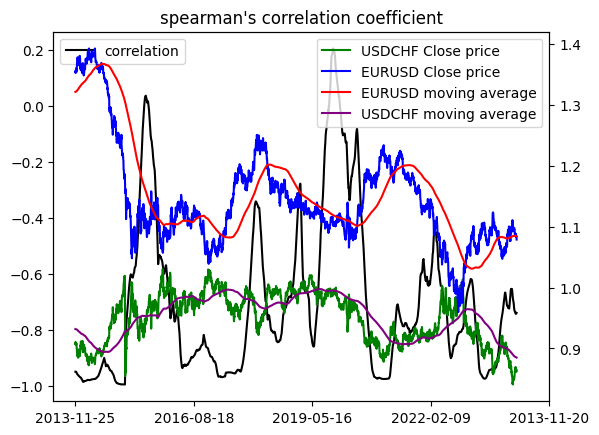

In [59]:
fx_correlation()